In [61]:
import torch
from torch import nn, optim, Tensor
from torch.nn import functional as F
import gymnasium as gym
from torchviz import make_dot
import matplotlib.pyplot as plt
import numpy as np

# Deep Q-Network for CartPole

DQN is a value-based method learning $Q^*$ with a deep network $Q_\theta$.

We'll implement it as a MLP. Consider `CartPole-v1`'s observation & action space:
$$\mathcal{S}\subset \mathbb{R}^4,~ \mathcal{A} = \{ 0, 1 \}$$

Therefore, as it has a discrete action space, we'll let the estimator take $s$ and produce both $Q_\theta(s, a)~(a=0,1)$ as output.

In [62]:
class Qnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcs = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 2),
        )
    
    def forward(self, state):
        q = self.fcs(state)
        return q

In [ ]:
gamma = 0.99
lr = 0.002
env = gym.make('CartPole-v1', render_mode=None)
net = Qnet()
opt = optim.Adam(net.parameters(), lr=lr)

Value-based methods use dererministic policy $\pi(a|s) = 1 - \varepsilon \iff a = \argmax\limits_{a} ~Q_\theta(s,a)$:

In [ ]:
eps = 0.001

def policy(q: Tensor, qloss) -> int:
    explore = torch.bernoulli(
        torch.tensor(eps) + torch.exp(-qloss) * 0.02
        ).item()
    action = torch.argmax(q).item()
    if explore == 1:
        return abs(1 - action) # type: ignore
    else:
        return action # type: ignore

In [ ]:
def train(net, env):
    obs, _ = env.reset()
    tot_reward = 0
    tot_loss = torch.tensor(0.)

    scale = torch.tensor([4.8, 1, 0.418, 1])
    q_last = None
    reward_last = None
    loss = torch.tensor(0.)
    t = 0
    while True:
        q = net(torch.from_numpy(obs) / scale)
        if q_last != None and reward_last != None:
            qh = reward_last + gamma * torch.max(q)
            loss = F.mse_loss(q_last, qh) * gamma ** t
            tot_loss += loss
        action = policy(q, loss)
        obs, reward, term, trunc, _ = env.step(action)

        tot_reward += float(reward)
        reward_last = float(reward)
        q_last = q[action]

        if term or trunc: break
        t = t + 1

    return tot_loss, tot_reward

In [66]:
def batch(results: list[tuple[Tensor, float]]) -> tuple[Tensor, float]:
    loss = reward = 0.
    for l, r in results:
        loss += l
        reward += r
    t = len(results)
    loss /= t; reward /= t
    return loss, reward # type: ignore

Text(0, 0.5, 'qloss')

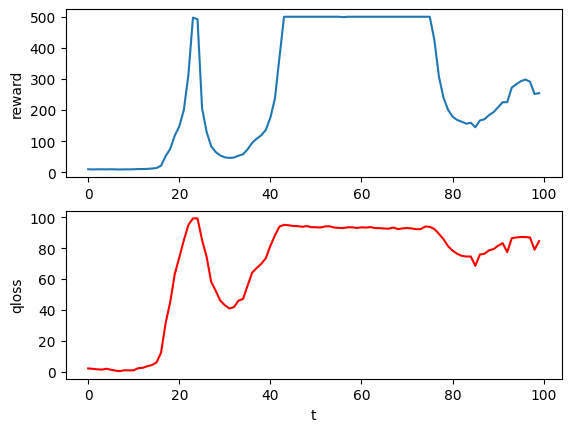

In [ ]:
epochs = 100; batches = 10
metrics = []
for e in range(epochs):
    loss, reward = batch([train(net, env) for _ in range(batches)])
    opt.zero_grad()
    loss.backward()
    opt.step()
    metrics.append({
        'tot_reward': reward,
        'qloss': loss.item(),
    })

plt.subplot(211)
plt.plot([m['tot_reward'] for m in metrics])
plt.ylabel('reward')
plt.subplot(212)
plt.plot([m['qloss'] for m in metrics], 'r')
plt.xlabel('t')
plt.ylabel('qloss')

In [68]:
# env = gym.make('CartPole-v1', render_mode='human')
# _, r = train(net, env, 1000)
# env.close()
# r